In [18]:
%matplotlib inline

from matplotlib import image
from matplotlib import pyplot as plt
import numpy as np
import numpy.matlib
import cv2
from skimage import io
import sys
from scipy import ndimage, signal
from random import randint, gauss
import math
from skimage.color import rgba2rgb, rgb2gray
import time

<Figure size 432x288 with 0 Axes>

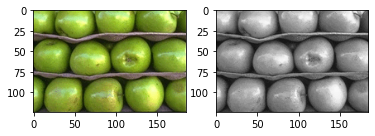

In [19]:
# pre-process the image
apples = image.imread('../images/apples.png')
# remove the alpha channel
a = rgba2rgb(apples)
# convert its colormap to gray
inputTexture = rgb2gray(a)  
# these numbers will be our baseline
[m, n] = inputTexture.shape

# display the processed images

plt.figure()
fig, arr = plt.subplots(1,2) 
arr[0].imshow(a)
arr[1].imshow(inputTexture, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)

In [20]:
# PSEUDO: Pick size of block and size of overlap
# the values are taken from the MATLAB implementation

magnification = 3 # 3 times bigger than the original size of the image
w = 50 # size of the patch
o = round(w/3) # size of overlap between the patches
m1 = math.ceil(m*magnification/w)*w+o # output row size after synthesis
n1 = math.ceil(n*magnification/w)*w+o # output column size after synthesis 
outputTexture = np.zeros([m1,n1]) # output image in grayscale
outputTexture1 = np.zeros([m1,n1,3]) # output image in rgb

In [21]:
# find the nearest patch (grayscale, color)
def givePatch(a,inputTexture,temp1,mask):
    temp2 = np.linalg.multi_dot([temp1,temp1,mask])
    temp3 = np.multiply(inputTexture, inputTexture)
    temp3 = signal.convolve2d(temp3, np.rot90(mask, 2), mode='valid')
    temp4 = signal.convolve2d(inputTexture, np.rot90(np.multiply(temp1, mask), 2), mode='valid')
    errors = np.sum(temp2.reshape(-1, 1))+temp3-2*temp4
    minerror = abs(np.min(errors.reshape(-1, 1)))
    [x,y] = np.where(errors <= minerror*1.1)
    randInt = randint(0, len(x))
    [m,n] = mask.shape
    nearPatch = inputTexture[x[randInt]:x[randInt]+m,y[randInt]:y[randInt]+n]
    nearPatch1 = a[x[randInt]:x[randInt]+m,y[randInt]:y[randInt]+n,:]
    return nearPatch, nearPatch1

In [22]:
# find the minimum error boundary to reduce the blockiness
# minimum error is computed as a minimum cost path through the error surface at the overlap
def findBoundaryHelper1(error):
    x, y = error.shape[0], error.shape[1] 
    path = np.zeros([x, y])
    cost = np.zeros([x, y])
    cost[x-1,:] = error[x-1,:]
    for i in range(x-2, 0, -1):
        mintree = np.array([np.append(float('+inf'), cost[i,0:y-1]), cost[i,:], np.append(cost[i,1:y], float('+inf'))], dtype=object)+ error[i-1,:] 
        cost[i,:] = np.min(mintree, axis = 0)
        path[i,:] = np.argmin(mintree, axis=0)
    np.where(path==1, path, 0)
    np.where(path==0, path, -1)
    np.where(path==2, path, 1)
    return cost, path

In [23]:
# declare the minimum cost path to be the boundary of the new block
def findBoundaryHelper2(path, ind):
    m = path.shape[1]
    boundary = np.zeros([path.shape[0], path.shape[1]])
    boundary[0,0:ind] = 1
    prev = ind - 1
    for i in range(1, m-1):
        prev = prev + path[i, int(prev)]
        boundary[i, 0:int(prev)] = 1
    return boundary

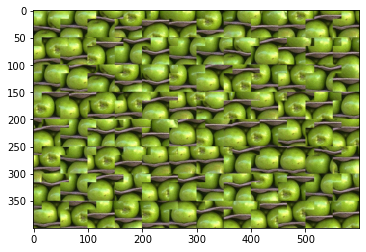

In [24]:
# PSEUDO: synthesize blocks in raster order
# loop over the number of patches - vertically
for i in range(0, math.floor(m1/w)):
    # loop over the number of patches - horizontally
    for j in range(0, math.floor(n1/w)):
        # create a mask to check the overlaps later
        mask = np.zeros([w+o,w+o])
        # nth patch
        temp1 = outputTexture[i*w:(i+1)*w+o,j*w:(j+1)*w+o] 
        # 1st patch
        if(i==0 and j == 0):
            # will be just the original first patch; update both grayscale and color images
            outputTexture[0:w+o,0:w+o] = inputTexture[0:w+o,0:w+o]
            outputTexture1[0:w+o,0:w+o,:] = a[0:w+o,0:w+o,:]
            continue
        # PSEUDO: search input texture for block that satisfies overlap constraints(above and left)
        # any patches in the first row other than the very first patch
        elif(i==0):
            # overlapped part is covered by the previous patch
            mask[:,0:o] = 1

            [nearPatch, nearPatch1] = givePatch(a,inputTexture,temp1,mask)
            # error surface between the newly chosen patch and the old patches at the overlap area
            error = np.power((np.multiply(nearPatch, mask) - np.multiply(temp1, mask)), 2)
            error = error[:,0:o]

            [cost,path] = findBoundaryHelper1(error)
            boundary = np.zeros([w+o, w+o])
            ind = int(np.argmin(cost[0,:]))
            boundary[:,0:o] = findBoundaryHelper2(path, ind)
            
        # PSEUDO: search input texture for block that satisfies overlap constraints(above and left)
        # any patches in the first column other than the very first patch
        elif(j==0):
            # overlapped part is covered by the previous patch
            mask[0:o,:] = 1
            
            [nearPatch,nearPatch1] = givePatch(a,inputTexture,temp1,mask)
            error = np.power((np.multiply(nearPatch, mask) - np.multiply(temp1, mask)), 2)
            error = error[0:o,:]
            [cost,path] = findBoundaryHelper1(error.T)
            boundary = np.zeros([w+o,w+o])
            ind = int(np.argmin(cost[0,:]))
            boundary[0:o,:] = (findBoundaryHelper2(path,ind)).T
            
        else:
            # overlapped parts are covered by the previous patch
            mask[:,0:o] = 1
            mask[0:o,:] = 1
            
            [nearPatch, nearPatch1] = givePatch(a,inputTexture,temp1,mask)
            # square the error; check if the near patch and the current patch look alike
            error = np.power((np.multiply(nearPatch, mask) - np.multiply(temp1, mask)), 2)
            
            # since the patch is neighboring with other synthesized patches, we need to consider both sides of boundaries
            error1 = error[0:o,:]
            error2 = error[:,0:o]
            [cost1,path1] = findBoundaryHelper1(error1.T) 
            [cost2,path2] = findBoundaryHelper1(error2)
            
            cost = np.add(cost1[0:o,:], cost2[0:o,:])
            boundary =  np.zeros([w+o,w+o])
    
            ind = int(np.argmin(np.diag(cost)))
        
            # declare the minimum cost path to be the boundary of the new block
            boundary[0:o,ind:w+o] = (findBoundaryHelper2(path1[ind:o+w,:],o-ind)).T
            boundary[ind:o+w,0:o] = findBoundaryHelper2(path2[ind:o+w,:], ind)
            
            boundary[0:ind,0:ind] = 1
        
        # 4. paste new block into resulting texture- use dynamic programming to compute minimal error boundary cut
        smoothBoundary = boundary
        # create a color version of boundary
        smoothBoundary1 = numpy.repeat(boundary[:, :, np.newaxis], 3, axis=2)
        # 1- is needed since it is a grayscale image
        temp2 = np.multiply(temp1, smoothBoundary) + np.multiply(nearPatch, (1-smoothBoundary))
        outputTexture[i*w:(i+1)*w+o,j*w:(j+1)*w+o] = temp2
        outputTexture1[i*w:(i+1)*w+o,j*w:(j+1)*w+o,:] = np.multiply(outputTexture1[i*w:(i+1)*w+o, j*w:(j+1)*w+o,:], smoothBoundary1) + np.multiply(nearPatch1, (1-smoothBoundary1))
output = outputTexture1[0:m1-o,0:n1-o,:]
plt.imshow(output)